In [2]:
import argparse
import torch
import torch.nn as nn
from tqdm import tqdm
from typing import Dict, Iterator

from torch.utils.data import DataLoader

from datasets.HMDB51Dataset_task3 import HMDB51Dataset
from models import model_creator
from utils import statistics

%load_ext autoreload
%autoreload 2

In [3]:
def create_datasets(
        frames_dir: str,
        annotations_dir: str,
        split: HMDB51Dataset.Split,
        clip_length: int,
        crop_size: int,
        temporal_stride: int,
        num_segments: int, 
        num_spatial_crops: int
) -> Dict[str, HMDB51Dataset]:
    """
    Creates datasets for training, validation, and testing.

    Args:
        frames_dir (str): Directory containing the video frames (a separate directory per video).
        annotations_dir (str): Directory containing annotation files.
        split (HMDB51Dataset.Split): Dataset split (TEST_ON_SPLIT_1, TEST_ON_SPLIT_2, TEST_ON_SPLIT_3).
        clip_length (int): Number of frames of the clips.
        crop_size (int): Size of spatial crops (squares).
        temporal_stride (int): Receptive field of the model will be (clip_length * temporal_stride) / FPS.

    Returns:
        Dict[str, HMDB51Dataset]: A dictionary containing the datasets for training, validation, and testing.
    """
    datasets = {}
    for regime in HMDB51Dataset.Regime:
        datasets[regime.name.lower()] = HMDB51Dataset(
            frames_dir,
            annotations_dir,
            split,
            regime,
            clip_length,
            crop_size,
            temporal_stride,
            num_segments, 
            num_spatial_crops
        )
    
    return datasets


def create_dataloaders(
        datasets: Dict[str, HMDB51Dataset],
        batch_size: int,
        batch_size_eval: int = 8,
        num_workers: int = 2,
        pin_memory: bool = True
    ) -> Dict[str, DataLoader]:
    """
    Creates data loaders for training, validation, and testing datasets.

    Args:
        datasets (Dict[str, HMDB51Dataset]): A dictionary containing datasets for training, validation, and testing.
        batch_size (int, optional): Batch size for the data loaders. Defaults to 8.
        num_workers (int, optional): Number of worker processes for data loading. Defaults to 2.
        pin_memory (bool, optional): Whether to pin memory in DataLoader for faster GPU transfer. Defaults to True.

    Returns:
        Dict[str, DataLoader]: A dictionary containing data loaders for training, validation, and testing datasets.
    """
    dataloaders = {}
    for key, dataset in datasets.items():
        dataloaders[key] = DataLoader(
            dataset,
            batch_size=(batch_size if key == 'training' else batch_size_eval),
            shuffle=(key == 'training'),  # Shuffle only for training dataset
            collate_fn=dataset.collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
            
    return dataloaders

In [27]:
parser = argparse.ArgumentParser(description='Train a video classification model on HMDB51 dataset.')

parser.frames_dir = "/ghome/group08/c6/week5/frames"
parser.annotations_dir = "/ghome/group08/c6/week5/data/hmdb51/testTrainMulti_601030_splits"
parser.clip_length = 4
parser.crop_size = 160
parser.temporal_stride = 12
parser.model_name = "mvit_v2_xs"
parser.load_pretrain = False
parser.num_workers = 2
parser.device = "cpu"
parser.batch_size = 16
parser.batch_size_eval = 16
parser.num_segments = 5
parser.num_spatial_crops = 1

args = parser

# Create datasets
datasets = create_datasets(
    frames_dir=args.frames_dir,
    annotations_dir=args.annotations_dir,
    split=HMDB51Dataset.Split.TEST_ON_SPLIT_1, # hardcoded
    clip_length=args.clip_length,
    crop_size=args.crop_size,
    temporal_stride=args.temporal_stride,
    num_segments=args.num_segments,
    num_spatial_crops=args.num_spatial_crops
)

# Create data loaders
loaders = create_dataloaders(
    datasets,
    args.batch_size,
    batch_size_eval=args.batch_size_eval,
    num_workers=args.num_workers
)

model = model_creator.create(args.model_name, args.load_pretrain, datasets["training"].get_num_classes())
# model.load_state_dict(torch.load("../pretrained/mvit_v2_xs.pth", map_location=args.device))

In [28]:

from collections import OrderedDict
params = torch.load("../pretrained/mvit_v2_xs.pth", map_location=args.device)

new_params = OrderedDict()
for k,v in params.items():
    if 'rel_pos_h' in k or 'rel_pos_w' in k or 'rel_pos_t' in k:
        new_params[k] = v[:model.state_dict()[k].shape[0]]
        # print(model.state_dict()[k].shape, v.shape)
    else:
        new_params[k] = v

model.load_state_dict(new_params)

<All keys matched successfully>

In [29]:
model.eval()
all_labels = []
all_predictions = []
for batch in tqdm(loaders['testing'], total=len(loaders['testing'])):
    # Gather batch and move to device
    clips, labels = batch['clips'].to(args.device), batch['labels'].to(args.device)
    # Forward pass
    with torch.no_grad():
        outputs = model(clips).argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

def aggregation_function(scores, num_segments, num_crops):
    total_n, n_classes = scores.shape
    batch_size = total_n // (num_segments * num_crops)

    aggregated_outputs = torch.zeros((batch_size, n_classes), device=scores.device)
    for i in range(batch_size):
        # Extract scores for each segment-crop combination
        segment_crop_scores = scores[i * num_segments * num_crops: (i + 1) * num_segments * num_crops]

        # Reshape scores to separate segments and crops
        segment_crop_scores = segment_crop_scores.reshape((num_segments, num_crops, n_classes))

        # Average scores across crops for each segment
        segment_scores = segment_crop_scores.mean(axis=1)

        # Aggregate scores across segments
        aggregated_outputs[i, :] = segment_scores.mean(axis=0)

    return aggregated_outputs

def evaluate(
        model: nn.Module, 
        valid_loader: DataLoader, 
        loss_fn: nn.Module,
        num_segments: int,
        num_spatial_crops: int,
        device: str,
        description: str = ""
    ) -> None:
    """
    Evaluates the given model using the provided data loader and loss function.

    Args:
        model (nn.Module): The neural network model to be validated.
        valid_loader (DataLoader): The data loader containing the validation dataset.
        loss_fn (nn.Module): The loss function used to compute the validation loss (not used for backpropagation)
        device (str): The device on which the model and data should be processed ('cuda' or 'cpu').
        description (str, optional): Additional information for tracking epoch description during training. Defaults to "".

    Returns:
        None
    """
    model.eval()
    pbar = tqdm(valid_loader, desc=description, total=len(valid_loader))
    loss_valid_mean = statistics.RollingMean(window_size=len(valid_loader))
    hits = count = 0 # auxiliary variables for computing accuracy
    all_labels = []
    all_predictions = []
    for batch in pbar:
        # Gather batch and move to device
        clips, labels = batch['clips'].to(device), batch['labels'].to(device)
        # Forward pass
        with torch.no_grad():
            outputs = model(clips)
            scores = torch.nn.functional.log_softmax(outputs, dim=-1)
            # Agregate outputs per video
            aggregated_outputs = aggregation_function(scores, num_segments, num_spatial_crops)
            # Compute loss (just for logging, not used for backpropagation)
            loss = loss_fn(aggregated_outputs, labels) 
            # Compute metrics
            loss_iter = loss.item()
            hits_iter = torch.eq(aggregated_outputs.argmax(dim=1), labels).sum().item()
            hits += hits_iter
            count += len(labels)
            # Update progress bar with metrics
            pbar.set_postfix(
                loss=loss_iter,
                loss_mean=loss_valid_mean(loss_iter),
                acc=(float(hits_iter) / len(labels)),
                acc_mean=(float(hits) / count)
            )
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(aggregated_outputs.argmax(dim=1).cpu().numpy())
    return all_labels, all_predictions, loss_valid_mean(loss_iter), float(hits) / count

loss_fn = nn.CrossEntropyLoss()
all_labels, all_predictions, mean_loss, mean_acc  = evaluate(model, loaders['testing'], loss_fn, args.num_segments, args.num_spatial_crops, args.device, description=f"Testing")
print(f"Mean loss: {mean_loss:.4f}, Mean accuracy: {mean_acc:.4f}")

  0%|          | 0/95 [00:00<?, ?it/s]

Testing: 100%|██████████| 95/95 [05:03<00:00,  3.20s/it, acc=0.154, acc_mean=0.0514, loss=3.4, loss_mean=4.49]  

Mean loss: 4.4996, Mean accuracy: 0.0514


In [ ]:
# Calculate per-class accuracies for the baseline
from sklearn.metrics import accuracy_score

unique_labels = set(all_labels)
class_accuracies_baseline = {}

for label in unique_labels:
    idxs = [i for i, x in enumerate(all_labels) if x == label]
    class_preds = [all_predictions[i] for i in idxs]
    class_labels = [all_labels[i] for i in idxs]
    class_accuracies_baseline[label] = accuracy_score(class_labels, class_preds)

print(class_accuracies_baseline)

In [ ]:
# Calculate per-class accuracies for the new model
from sklearn.metrics import accuracy_score

unique_labels = set(all_labels)
class_accuracies_new_model = {}

for label in unique_labels:
    idxs = [i for i, x in enumerate(all_labels) if x == label]
    class_preds = [all_predictions[i] for i in idxs]
    class_labels = [all_labels[i] for i in idxs]
    class_accuracies_new_model[label] = accuracy_score(class_labels, class_preds)

print(class_accuracies_new_model)

In [ ]:
# PLOT CONFUSION MATRIX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = datasets["training"].CLASS_NAMES

cm = confusion_matrix(all_labels, all_predictions)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Confusion Matrix')
plt.show()

def highlight_errors(confusion_matrix, class_names):
    np.fill_diagonal(confusion_matrix, 0)  # Ignore diagonal elements (true positives)
    high_error_indices = np.where(confusion_matrix > np.percentile(confusion_matrix, 95))
    for row, col in zip(*high_error_indices):
        if confusion_matrix[row, col] > 0.3:
            print(f"High misclassification from {class_names[row]} to {class_names[col]}: {confusion_matrix[row, col]}")

highlight_errors(cm, class_names)

In [ ]:
# from scipy.cluster.hierarchy import dendrogram, linkage

# def plot_dendrogram(confusion_matrix, class_names):
#     # Use linkage to perform hierarchical clustering
#     Z = linkage(confusion_matrix, 'ward')
#     plt.figure(figsize=(12, 6))
#     dendrogram(Z, labels=class_names, leaf_rotation=90)
#     plt.title('Hierarchical Clustering Dendrogram')
#     plt.xlabel('Class')
#     plt.ylabel('Distance')
#     plt.xticks(fontsize=10)
#     plt.show()

# plot_dendrogram(cm, class_names)

In [ ]:
import matplotlib.pyplot as plt

class_names = datasets["training"].CLASS_NAMES

labels = list(class_accuracies_baseline.keys())
accuracies = [class_accuracies_baseline[lbl] * 100 for lbl in labels]  # Convert fractions to percentages

# Use a visually appealing color scheme, such as a sequential palette
colors = plt.cm.viridis([i/len(labels) for i in range(len(labels))])

# Create a professional looking bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, accuracies, color=colors)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Per-Class Accuracy Bar Plot', fontsize=16)
plt.xticks(rotation=90, fontsize=10)  # Rotate class labels for better visibility
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Set y-axis to show percentage
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')  # Add gridlines
plt.tight_layout()  # Adjust layout to make room for label rotation

# Optional: Adding value labels on bars
for bar in bars:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()


In [ ]:
# Example data
class_accuracies_model1 = class_accuracies_baseline
class_accuracies_model2 = class_accuracies_new_model
#class_accuracies_model2 = {k: v + 0.1 for k, v in class_accuracies_baseline.items()} # CHANGE THIS TO YOUR OWN DATA (PREVIOUS LINE)

# Calculating relative increase in accuracy
relative_increase = {}
for lbl in class_accuracies_baseline.keys():
    initial = class_accuracies_baseline[lbl]
    new = class_accuracies_model2[lbl]
    if initial != 0:
        increase = (new - initial) / initial * 100
    else:
        increase = 0
    relative_increase[lbl] = increase

# Assuming class names as labels
class_names = datasets["training"].CLASS_NAMES

# Sort the increase and labels accordingly
sorted_items = sorted(relative_increase.items(), key=lambda x: x[1], reverse=True)
sorted_labels, sorted_increases = zip(*sorted_items)
sorted_names = [class_names[lbl] for lbl in sorted_labels]

# Use a visually appealing color scheme
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_labels)))

# Create a professional looking bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_names, sorted_increases, color=colors)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Relative Increase in Accuracy (%)', fontsize=14)
plt.title('Relative Increase in Per-Class Accuracy', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(min(sorted_increases) - 50, max(sorted_increases) + 50)
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
plt.tight_layout()
plt.axhline(y=0.0, color='black', linewidth=1, linestyle='-')

# Adding value labels on bars
for bar in bars:
    yval = bar.get_height()
    if yval != 0:
        horizontal_offset = bar.get_width()/2 if yval > 0 else 1.25*bar.get_width()
        vertical_offset = yval + 1 if yval > 0 else 0
        plt.text(bar.get_x() + horizontal_offset, vertical_offset, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8, rotation=45)

plt.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Creating a sample dataset
data = {
    'Model': ['Model A', 'Model B', 'Model C', 'Model D'],
    'Accuracy': [92.5, 88.3, 90.1, 93.7],   # in percentage
    'GFLOPs': [3.5, 1.2, 2.7, 4.1],         # in billions (10^9)
    'Parameters': [25, 10, 18, 30]          # in millions (10^6)
}

df = pd.DataFrame(data)

# Create a scale for bubble sizes that is easier to understand in the legend
df['Bubble Size'] = df['Parameters']

# Creating the bubble plot using Plotly Express
fig = px.scatter(df, x='GFLOPs', y='Accuracy', size='Bubble Size', color='Model',
                 hover_name='Model', size_max=60, 
                 labels={"GFLOPs": "GFLOPs (in billions)", "Accuracy": "Accuracy (%)", "Bubble Size": "Parameters (in millions)"},
                 title="Interactive Bubble Plot: Model Performance and Complexity")

# Adding legend for bubble sizes explicitly if needed
fig.update_layout(legend_title_text='Model & Parameters Scale')

# Show plot
fig.show()


In [11]:
pd.read_csv('MCV-M6-ActionClassificationTask-Experiments.xlsx - Experiments (team 4).csv', sep=';')

,Models,Parameters (M),GFLOPs,Test accuracy (%)
0,X3D-XS (baseline),0.31,0.09,16.02
1,X3D-XS-2x3,0.31,0.09,16.68
2,X3D-XS-pretrained,0.31,0.09,57.61
3,X3D-XS-2x3-pretrained,0.31,0.09,54.32
4,X3D-XXS,0.11,0.06,16.61
5,MVIT.V2-XS,0.31,0.42,10.50
6,X3D-M-pretrained,0.31,0.51,67.37
7,X3D-L-pretrained,0.54,1.98,63.22
8,MVIT.V2-S-pretrained,3.43,6.45,65.79
9,MVIT.V1-B-pretrained,3.63,7.08,62.43


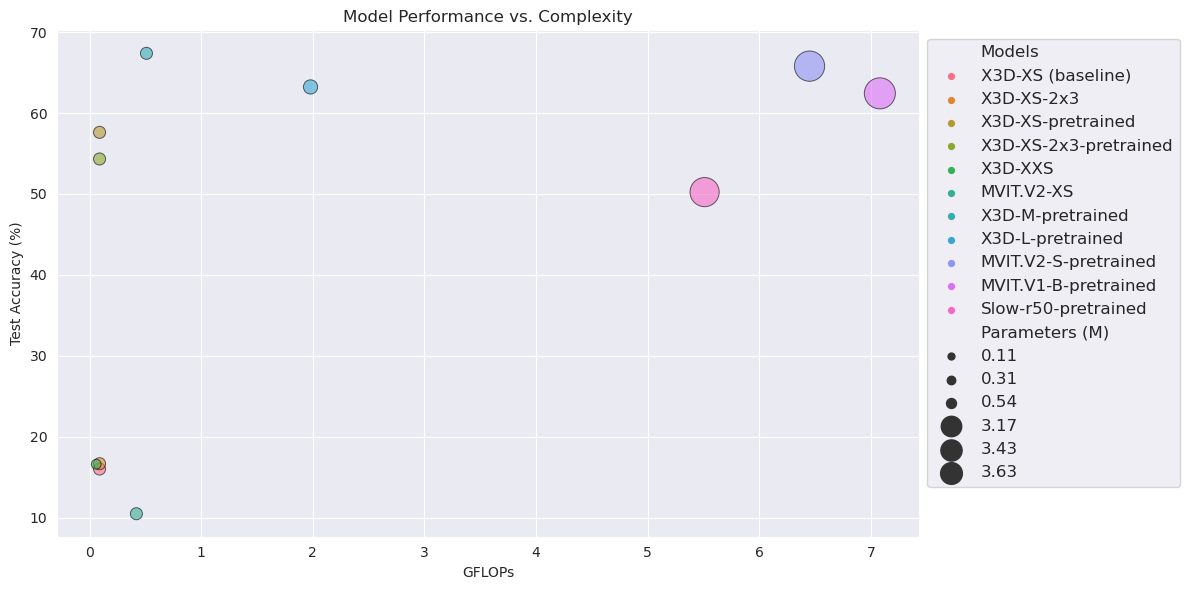

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('MCV-M6-ActionClassificationTask-Experiments.xlsx - Experiments (team 4).csv', sep=';')

plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
# use the scatterplot function
sns.scatterplot(data=df, x="GFLOPs", y="Test accuracy (%)", size="Parameters (M)", hue="Models", edgecolor="black", alpha=0.6, sizes=(50, 500))

plt.xlabel("GFLOPs")
plt.ylabel("Test Accuracy (%)")
plt.title("Model Performance vs. Complexity")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=12, markerscale=0.7)

# show the graph
plt.tight_layout()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torchvision
from fvcore.nn import FlopCountAnalysis
from utils import model_analysis

def create(model_name: str, load_pretrain: bool, num_classes: int) -> nn.Module:
    if model_name == 'x3d_xs':
        return create_x3d_xs(load_pretrain, num_classes)
    
    elif model_name == 'x3d_m':
        return create_x3d_m(load_pretrain, num_classes)
    
    elif model_name == 'x3d_l':
        return create_x3d_l(load_pretrain, num_classes)
    
    elif model_name == 'x3d_xxs':
        return create_x3d_xxs(load_pretrain, num_classes)
    
    elif model_name == 'mvit_v1_b':
        return create_mvit_v1_b(load_pretrain, num_classes)

    elif model_name == 'mvit_v2_s':
        return create_mvit_v2_s(load_pretrain, num_classes)
    
    elif model_name == 'mvit_v2_xs':
        return create_mvit_v2_xs(load_pretrain, num_classes)

    elif model_name == 'slowfast_r50':
        return create_slowfast_r50(load_pretrain, num_classes)

    else:
        raise ValueError(f"Model {model_name} not supported")
    
def create_x3d_xxs(load_pretrain, num_classes):
    # best parameters for x3d_xs are 4x12 (clip-length x stride) (they call it frame length x sample rate)
    # and resolution 160x160
    from models.x3d import create_x3d as create_x3d_xxs
    return create_x3d_xxs()

def create_x3d_xs(load_pretrain, num_classes):
    # best parameters for x3d_xs are 4x12 (clip-length x stride) (they call it frame length x sample rate)
    # and resolution 182x182 (en vd son 160x160 pero el profe se equivocó y utilizó 182x182)
    model = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_xs', pretrained=load_pretrain)
    model.blocks[5].proj = nn.Identity()
    return nn.Sequential(
        model,
        nn.Linear(2048, num_classes, bias=True),
    )

def create_x3d_m(load_pretrain, num_classes):
    # best parameters for x3d_m are 16x5 (clip-length x stride) (they call it frame length x sample rate)
    # and resolution 224x224
    model = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_m', pretrained=load_pretrain)
    model.blocks[5].proj = nn.Identity()
    return nn.Sequential(
        model,
        nn.Linear(2048, num_classes, bias=True),
    )

def create_x3d_l(load_pretrain, num_classes):
    # best parameters for x3d_l are 16x5 (clip-length x stride) (they call it frame length x sample rate)
    # and resolution 312x312
    model = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_l', pretrained=load_pretrain)
    model.blocks[5].proj = nn.Identity()
    return nn.Sequential(
        model,
        nn.Linear(2048, num_classes, bias=True),
    )

def create_mvit_v1_b(load_pretrain, num_classes):
    # best parameters for mvit_v2_s are 16x7.5 (clip-length x stride) (they call it frame length x sample rate)
    # and num_segments = 5 and resolution 224x224
    model = torchvision.models.video.mvit_v1_b(weights='KINETICS400_V1' if load_pretrain else None)
    model.head[1] = torch.nn.Linear(768, num_classes, bias=True)

    return model
    
def create_mvit_v2_s(load_pretrain, num_classes):
    # best parameters for mvit_v2_s are 16x7.5 (clip-length x stride) (they call it frame length x sample rate)
    # and num_segments = 5 and resolution 224x224
    model = torchvision.models.video.mvit_v2_s(weights='KINETICS400_V1' if load_pretrain else None)
    model.head[1] = torch.nn.Linear(768, num_classes, bias=True)

    return model

def create_mvit_v2_xs(load_pretrain, num_classes):
    # best parameters for mvit_v2_s are 16x7.5 (clip-length x stride) (they call it frame length x sample rate)
    # and num_segments = 5 and resolution 224x224
    from models.mvit import mvit_v2_s as mvit_v2_xs
    model = mvit_v2_xs(weights=None)
    model.head[1] = torch.nn.Linear(384, num_classes, bias=True)

    return model
    

def print_model_summary(
        model: nn.Module,
        clip_length: int,
        crop_size: int,
        print_model: bool = True,
        print_params: bool = True,
        print_FLOPs: bool = True
    ) -> None:
    """
    Prints a summary of the given model.

    Args:
        model (nn.Module): The model for which to print the summary.
        clip_length (int): Number of frames of the clips.
        crop_size (int): Size of spatial crops (squares).
        print_model (bool, optional): Whether to print the model architecture. Defaults to True.
        print_params (bool, optional): Whether to print the number of parameters. Defaults to True.
        print_FLOPs (bool, optional): Whether to print the number of FLOPs. Defaults to True.

    Returns:
        None
    """
    if print_model:
        print(model)

    if print_params:
        num_params = sum(p.numel() for p in model.parameters())
        #num_params = model_analysis.calculate_parameters(model) # should be equivalent
        print(f"Number of parameters (M): {round(num_params / 10e6, 2)}")

    if print_FLOPs:
        num_FLOPs = model_analysis.calculate_operations(model, clip_length, crop_size, crop_size)
        print(f"Number of FLOPs (G): {round(num_FLOPs / 10e9, 2)}")

model = create('x3d_xs', True, 51)
print_model_summary(model, 8, 256, print_model=False, print_FLOPs=False)

Using cache found in /ghome/group08/.cache/torch/hub/facebookresearch_pytorchvideo_main


Number of parameters (M): 3.38
